<a href="https://colab.research.google.com/github/royn5618/Talks_Resources/blob/main/EuroPython2021/Building_Word2Vec_Model_on_Wikipedia_Texts_on_Programming_Languages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this example, I have used SPARQL Query to query the **Wikipedia Page Names**. The names are in **rdfs:label** property. Once I had the list of wikipedia page names, the next step is to get the contents using **Wikipedia Python Library**, process it and create a **Word2Vec model using Gensim**.

In [1]:
!pip install beautifulsoup4
!pip install wikipedia
!pip install SPARQLWrapper
!pip install gensim

  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11696 sha256=b00e5c202bf52219426f3ded8c7357d7af1180a7dede364a037498e23460b07d
  Stored in directory: /root/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built wikipedia
     |████████████████████████████████| 376 kB 5.5 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 


In [2]:
from SPARQLWrapper import SPARQLWrapper, JSON, N3
import pandas as pd
from bs4 import BeautifulSoup
import wikipedia

import re

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from gensim.models import Word2Vec # This is Gensim 3.6.0

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
sparql = SPARQLWrapper('https://dbpedia.org/sparql')

In [4]:
def exec_query(sparql, query):
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    results = pd.json_normalize(results['results']['bindings'])
    return results

**YAGO** (Yet Another Great Ontology) is an open source knowledge base developed at the Max Planck Institute for Computer Science in Saarbrücken.

Ref - https://en.wikipedia.org/wiki/YAGO_(database)

In [5]:
query = ''' SELECT ?thing, ?label 
WHERE { ?thing a dbo:ProgrammingLanguage; a dbo:Language; a yago:WikicatProgrammingLanguages; rdfs:label ?label .
FILTER(LANG(?label) = "en")} '''
query

' SELECT ?thing, ?label \nWHERE { ?thing a dbo:ProgrammingLanguage; a dbo:Language; a yago:WikicatProgrammingLanguages; rdfs:label ?label .\nFILTER(LANG(?label) = "en")} '

In [6]:
results = exec_query(sparql, query)
results.head()

,thing.type,thing.value,label.type,label.xml:lang,label.value
0,uri,http://dbpedia.org/resource/C++,literal,en,C++
1,uri,http://dbpedia.org/resource/CLU_(programming_l...,literal,en,CLU (programming language)
2,uri,http://dbpedia.org/resource/COBOL,literal,en,COBOL
3,uri,http://dbpedia.org/resource/COMIT,literal,en,COMIT
4,uri,http://dbpedia.org/resource/CPL_(programming_l...,literal,en,CPL (programming language)


In [7]:
wiki_page_list = list(set(results['label.value']))
len(wiki_page_list)

257

In [8]:
wiki_page_list

['IBM RPG',
 'Visual Basic for Applications',
 'Locomotive BASIC',
 'Caml',
 'C--',
 'Ada (programming language)',
 'Opa (programming language)',
 'PLEX (programming language)',
 'Seed7',
 'Clascal',
 'SPARK (programming language)',
 'Not Quite C',
 'Common Intermediate Language',
 'OpenGL Shading Language',
 'Pacbase',
 'Logtalk',
 'ML (programming language)',
 'Common Lisp',
 'Charm++',
 'BCPL',
 'Modula-2',
 'Simula',
 'MAD (programming language)',
 'SR (programming language)',
 'Tea (programming language)',
 'AspectJ',
 'Perl',
 'ALGOL 60',
 'Newsqueak',
 'Arc (programming language)',
 'Fortran',
 'COBOL',
 'Compiled language',
 'Real-time Programming Language',
 'Turing (programming language)',
 'AutoLISP',
 'FX-87',
 'Scientific Vector Language',
 'ALGOL W',
 'OptimJ',
 'OCaml',
 'Verilog',
 'ABSET',
 'Language Of Temporal Ordering Specification',
 'QML',
 'Pharo',
 'APL (programming language)',
 'MPD (programming language)',
 'VHDL',
 'Rebol',
 'Clarion (programming language)',


In [9]:
%%time
list_wiki_page_objs = []
for each_page in wiki_page_list:
  try:
    list_wiki_page_objs.append(wikipedia.page(each_page).content)
  except Exception as e:
    continue

CPU times: user 13.6 s, sys: 939 ms, total: 14.5 s
Wall time: 7min 14s


In [10]:
len(list_wiki_page_objs)

223

In [11]:
list_wiki_page_objs[0]

'RPG is a high-level programming language for business applications, introduced in 1959 for the IBM 1401. It is most well known as the primary programming language of IBM\'s midrange computer product line, including the IBM i operating system. RPG has traditionally featured a number of distinctive concepts, such as the program cycle, and the column-oriented syntax. The most recent version is RPG IV, which includes a number of modernization features, including free-form syntax.\n\n\n== Platforms ==\nThe RPG programming language originally was created by IBM for their 1401 systems. They also produced an implementation for the System/360, and it became the primary programming language for their midrange computer product line, (the System/3, System/32, System/34, System/38, System/36 and AS/400). There have also been implementations for the Digital VAX, Sperry Univac BC/7, Univac system 80, Siemens BS2000, Burroughs B700, B1700, Hewlett Packard HP 3000, the ICL 2900 series, Honeywell 6220 

In [12]:
wordnet_lemmatizer = WordNetLemmatizer()

def text_preprocessing(text):
  cleaned_text = re.sub(r'[^a-zA-Z\d\s\']+', '', text)
  tokenized_text = word_tokenize(cleaned_text.lower())
  lemmatized_text = [wordnet_lemmatizer.lemmatize(token) for token in tokenized_text]
  return lemmatized_text

In [13]:
%%time
list_wiki_page_objs_tokenized = [text_preprocessing(each_wiki_page_content) for each_wiki_page_content in list_wiki_page_objs]

CPU times: user 4.43 s, sys: 137 ms, total: 4.56 s
Wall time: 4.54 s


In [14]:
model = Word2Vec(list_wiki_page_objs_tokenized, max_vocab_size=200, min_count=5)

In [15]:
model.wv.most_similar('programming')

[('language', 0.9641199111938477),
 ('computer', 0.8455070853233337),
 ('implementation', 0.7936789989471436),
 ('fortran', 0.7877934575080872),
 ('software', 0.7842055559158325),
 ('based', 0.7779183387756348),
 ('python', 0.7745454907417297),
 ('development', 0.7593181133270264),
 ('available', 0.7500693798065186),
 ('standard', 0.7445951104164124)]

In [16]:
pca = PCA(n_components=2)

In [17]:
vocab = list(model.wv.vocab)

In [18]:
X_pca = pca.fit_transform(model.wv[vocab])

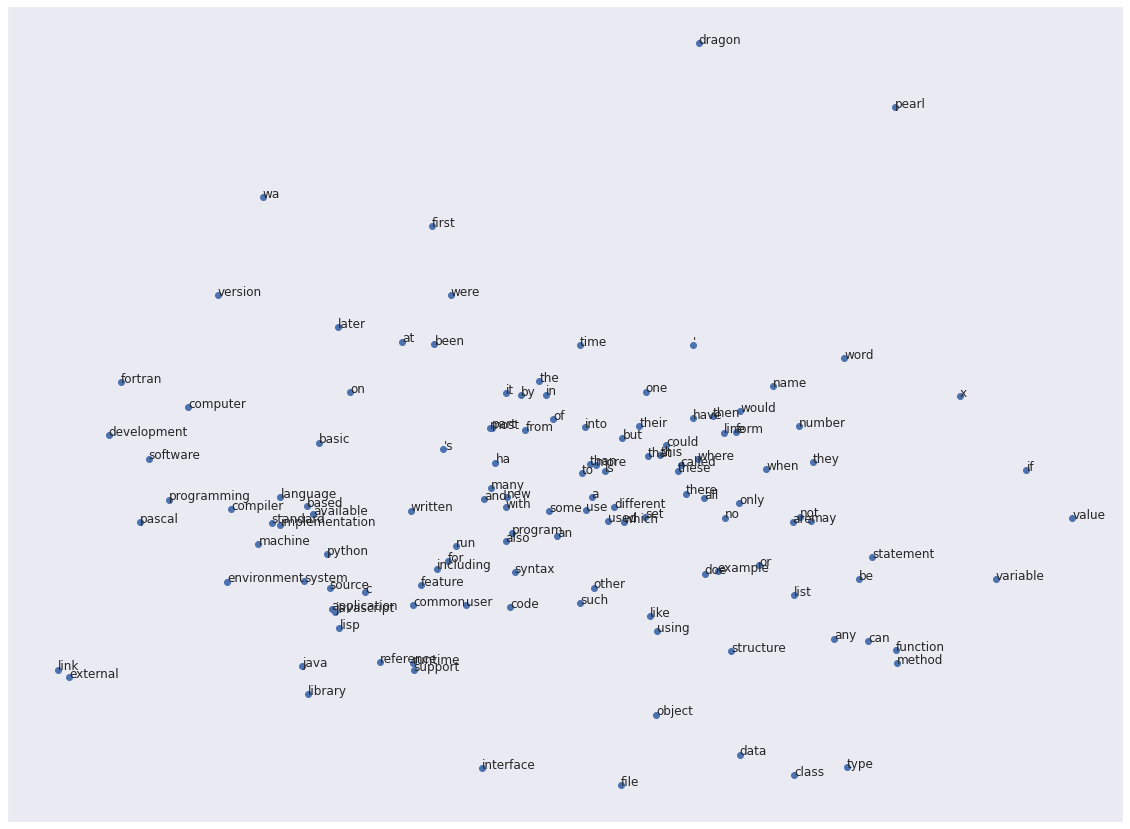

In [19]:
plt.figure(figsize=[20, 15])
plt.scatter(X_pca[:, 0], X_pca[:, 1])
for i, word in enumerate(vocab):
    plt.annotate(word, xy = (X_pca[i, 0], X_pca[i, 1]))
plt.xticks([])
plt.yticks([])
plt.show()

Thanks for visiting!